Install Necessary Libraries

Importing Dependencies

In [237]:
!pip install tensorflow  opencv-python matplotlib

In [296]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [297]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

GPU Settings

In [298]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Folder Settings

In [299]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [302]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

Collect Data

In [151]:
# http://vis-www.cs.umass.edu/lfw/

In [152]:
!tar -xf lfw.tgz

In [153]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

Positive Images

In [303]:
import uuid
# Import uuid library to generate unique image names
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\d3671d61-6b83-11ee-b38a-b06088d48e19.jpg'

In [304]:
#I wanna see myself befor continue

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    cv2.imshow('Image Collection',frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [305]:
#plt.imshow(frame)
frame.shape


(480, 640, 3)

In [306]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imganc = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imganc, frame)

    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgpos = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgpos, frame)

    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [307]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [310]:
import os
import uuid
img_path = os.path.join(ANC_PATH, '0746e075-6b84-11ee-b5ac-b06088d48e19.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

## Preprocessing of Images


Get Image Directories

In [311]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(30)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(30)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(30)

In [312]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\fb972222-6b83-11ee-8acd-b06088d48e19.jpg'


#### Scale and Resize

In [313]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [315]:
img = preprocess('data\\anchor\\0746e075-6b84-11ee-b5ac-b06088d48e19.jpg')

img.numpy().max() 

0.75441176

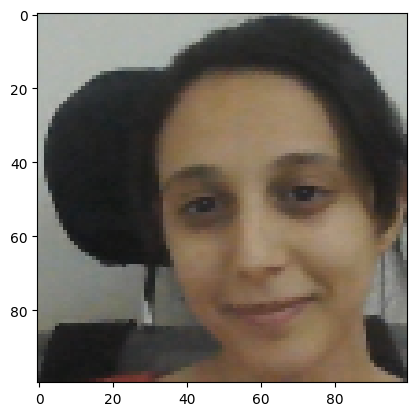

In [316]:
plt.imshow(img)

## Create Labelled Dataset

In [317]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [318]:
samples = data.as_numpy_iterator()
exampple = samples.next()
exampple

(b'data\\anchor\\e219dcd2-6b83-11ee-bbaf-b06088d48e19.jpg',
 b'data\\positive\\f7656b22-6b83-11ee-8736-b06088d48e19.jpg',
 1.0)

## Train - Test Split

In [319]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [320]:
res = preprocess_twin(*exampple)

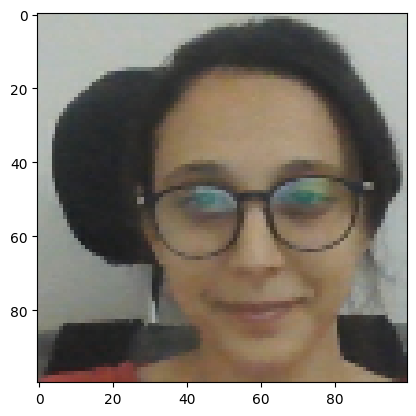

In [321]:
plt.imshow(res[1])

## Pipeline

In [322]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [323]:
train_samples=train_data.as_numpy_iterator()

In [324]:
train_sample=train_samples.next()
len(train_sample[0])

16

# Model Engineering

### Build Embedding Layer:

In [325]:
#model=(Conv+ ReLU+ MaxPooling)*3+ Conv+ Fully Connected+sigmoid

def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image') #100,100,3
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp) #91,91,64
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1) #46,46,64
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)#40,40,128
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)#20,20,128
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)#17,17,128
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)#9,9,128
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)#6,6,256
    f1 = Flatten()(c4)#9216
    d1 = Dense(4096, activation='sigmoid')(f1)#4096
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [326]:
embedding = make_embedding()


In [327]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_50 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 46, 46, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 20, 20, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 17, 17, 128)       26

### Build Distance Layer
How similar our images are:

In [328]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [329]:
l1 = L1Dist()

## Siamese Model

In [330]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)#output of shape 1
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [331]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

## Training

In [332]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

Establish Checkpoints

In [333]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

Build Train Step Function

In [334]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1.],
      dtype=float32)

In [61]:
tf.losses.BinaryCrossentropy??

In [335]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

Build Training Loop

In [336]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### Train the model

In [337]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
3/3 [==============================] - 42s 13s/step

 Epoch 2/50
3/3 [==============================] - 39s 12s/step

 Epoch 3/50
3/3 [==============================] - 40s 13s/step

 Epoch 4/50
3/3 [==============================] - 41s 13s/step

 Epoch 5/50
3/3 [==============================] - 41s 12s/step

 Epoch 6/50
3/3 [==============================] - 39s 12s/step

 Epoch 7/50
3/3 [==============================] - 38s 12s/step

 Epoch 8/50
3/3 [==============================] - 38s 12s/step

 Epoch 9/50
3/3 [==============================] - 38s 12s/step

 Epoch 10/50
3/3 [==============================] - 38s 12s/step

 Epoch 11/50
3/3 [==============================] - 38s 12s/step

 Epoch 12/50
3/3 [==============================] - 39s 12s/step

 Epoch 13/50
3/3 [==============================] - 41s 13s/st

## Evaluate the Model

In [338]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [339]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 2s 2s/step


array([[9.9953711e-01],
       [9.7039687e-05],
       [9.9599797e-01],
       [8.5880680e-07],
       [3.8637070e-04],
       [3.1468321e-06],
       [9.9990404e-01],
       [1.7496617e-05],
       [1.0000000e+00],
       [2.5167008e-05],
       [1.8852511e-04],
       [9.1738446e-05],
       [9.9999982e-01],
       [1.0000000e+00],
       [6.0829063e-07],
       [9.9999905e-01]], dtype=float32)

In [340]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1]

In [341]:
y_true

array([1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.],
      dtype=float32)

Calculate Metrics

In [342]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [343]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

Results

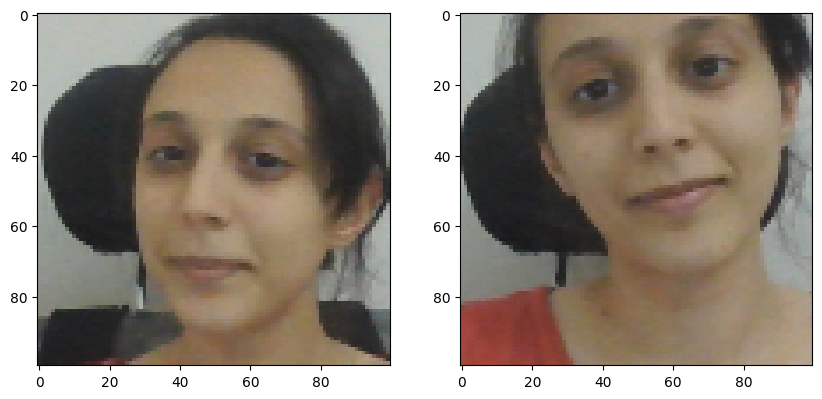

In [344]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

## Save Model

In [345]:
# Save weights
siamese_model.save('siamesemodel.h5')
L1Dist

__main__.L1Dist

In [346]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [347]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


array([[9.9953711e-01],
       [9.7039687e-05],
       [9.9599797e-01],
       [8.5880680e-07],
       [3.8637070e-04],
       [3.1468321e-06],
       [9.9990404e-01],
       [1.7496617e-05],
       [1.0000000e+00],
       [2.5167008e-05],
       [1.8852511e-04],
       [9.1738446e-05],
       [9.9999982e-01],
       [1.0000000e+00],
       [6.0829063e-07],
       [9.9999905e-01]], dtype=float32)

In [348]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# Real Timme Testing

In [349]:
os.listdir(os.path.join('application_data', 'verification_images'))

['007bed8a-6b84-11ee-a9b8-b06088d48e19.jpg',
 '034b7e06-6b84-11ee-b945-b06088d48e19.jpg',
 '056a319a-6b84-11ee-8a74-b06088d48e19.jpg',
 '07ae9aae-6b84-11ee-8448-b06088d48e19.jpg',
 '13f63022-6b84-11ee-a9d0-b06088d48e19.jpg',
 '144af7cf-6b84-11ee-a1e9-b06088d48e19.jpg',
 '14fbf7a7-6b84-11ee-b3e9-b06088d48e19.jpg',
 '159f3b2c-6b84-11ee-8aa8-b06088d48e19.jpg',
 '16c29751-6b84-11ee-9865-b06088d48e19.jpg',
 '16df0252-6b84-11ee-9645-b06088d48e19.jpg',
 '172b0beb-6b84-11ee-aa2f-b06088d48e19.jpg',
 '17f1f3f1-6b84-11ee-aca8-b06088d48e19.jpg',
 '182aa01f-6b84-11ee-8a8c-b06088d48e19.jpg',
 '19fae5c0-6b84-11ee-a8a2-b06088d48e19.jpg',
 '1a98aef3-6b84-11ee-9335-b06088d48e19.jpg',
 '1c451ff6-6b84-11ee-b413-b06088d48e19.jpg',
 '1c685593-6b84-11ee-a6e2-b06088d48e19.jpg',
 '1c8bd29d-6b84-11ee-a97a-b06088d48e19.jpg',
 '1cd2912c-6b84-11ee-9929-b06088d48e19.jpg',
 '1d4d327b-6b84-11ee-802f-b06088d48e19.jpg',
 '1d5b3188-6b84-11ee-8b9d-b06088d48e19.jpg',
 '1ebce504-6b84-11ee-948e-b06088d48e19.jpg',
 '1ee79d70

In [350]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [351]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\007bed8a-6b84-11ee-a9b8-b06088d48e19.jpg
application_data\verification_images\034b7e06-6b84-11ee-b945-b06088d48e19.jpg
application_data\verification_images\056a319a-6b84-11ee-8a74-b06088d48e19.jpg
application_data\verification_images\07ae9aae-6b84-11ee-8448-b06088d48e19.jpg
application_data\verification_images\13f63022-6b84-11ee-a9d0-b06088d48e19.jpg
application_data\verification_images\144af7cf-6b84-11ee-a1e9-b06088d48e19.jpg
application_data\verification_images\14fbf7a7-6b84-11ee-b3e9-b06088d48e19.jpg
application_data\verification_images\159f3b2c-6b84-11ee-8aa8-b06088d48e19.jpg
application_data\verification_images\16c29751-6b84-11ee-9865-b06088d48e19.jpg
application_data\verification_images\16df0252-6b84-11ee-9645-b06088d48e19.jpg
application_data\verification_images\172b0beb-6b84-11ee-aa2f-b06088d48e19.jpg
application_data\verification_images\17f1f3f1-6b84-11ee-aca8-b06088d48e19.jpg
application_data\verification_images\182aa01f-6b84-11ee-8a8c-b06

In [352]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## OpenCV Real Time Verification

In [353]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 165ms/step
True


In [354]:
np.sum(np.squeeze(results) > 0.9)

42

In [355]:
32/50

0.64

In [356]:
results

[array([[0.9999996]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[0.9999999]], dtype=float32),
 array([[0.9999999]], dtype=float32),
 array([[0.999813]], dtype=float32),
 array([[0.9999871]], dtype=float32),
 array([[0.99998814]], dtype=float32),
 array([[0.9999889]], dtype=float32),
 array([[0.9999921]], dtype=float32),
 array([[0.9999975]], dtype=float32),
 array([[0.99999845]], dtype=float32),
 array([[0.99999774]], dtype=float32),
 array([[0.9999944]], dtype=float32),
 array([[0.9999993]], dtype=float32),
 array([[0.999999]], dtype=float32),
 array([[0.99999905]], dtype=float32),
 array([[0.99999917]], dtype=float32),
 array([[0.9999996]], dtype=float32),
 array([[0.9999995]], dtype=float32),
 array([[0.9999992]], dtype=float32),
 array([[0.99999976]], dtype=float32),
 array([[0.9999992]], dtype=float32),
 array([[0.99999833]], dtype=float32),
 array([[0.9999977]], dtype=float32),
 array([[0.9